# Image similarity estimation using a Siamese Network with a contrastive loss

**Author:** Mehdi<br>
**Date created:** 2021/05/06<br>
**Last modified:** 2022/09/10<br>
**Description:** Similarity learning using a siamese network trained with a contrastive loss.

## Introduction

[Siamese Networks](https://en.wikipedia.org/wiki/Siamese_neural_network)
are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the
contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between
embeddings of similar classes, resulting in embedding spaces that reflect
the class segmentation of the training inputs.

## Setup

In [14]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

## Hyperparameters

In [33]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

## Load the MNIST dataset

In [20]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [17]:
print(x_train_val.shape)
print(y_train_val.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Define training and validation sets

In [21]:
# Keep 50% of train_val  in validation set / maybe we should try 70 30 or 60 40 
x_train, x_val = x_train_val[:40000], x_train_val[40000:] # war vorher 30000
y_train, y_val = y_train_val[:40000], y_train_val[40000:]
del x_train_val, y_train_val

## Create pairs of images

We will train the model to differentiate between digits of different classes. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair them with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).

In [22]:

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

We get:

**pairs_train.shape = (60000, 2, 28, 28)**

- We have 60,000 pairs
- Each pair contains 2 images
- Each image has shape `(28, 28)`

Split the training pairs

In [23]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the validation pairs

In [24]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

Split the test pairs

In [25]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


## Visualize pairs and their labels

In [10]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

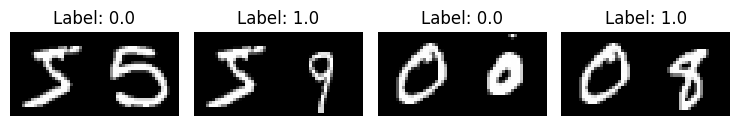

In [11]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect validation pairs

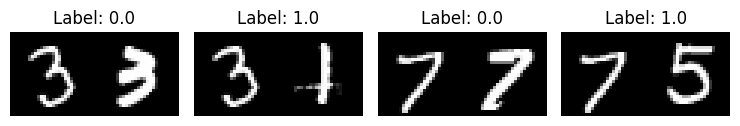

In [12]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

Inspect test pairs

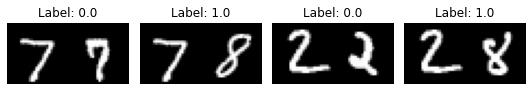

In [15]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [26]:
# CONTRASTIVE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese1 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [27]:
# BCE + DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese2 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Define the contrastive Loss

In [28]:

def cont_loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


## Dice Loss
https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

In [25]:

def dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice


    def dice_coef_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    
    return dice_coef_loss


## BCE Dice Loss
https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

In [29]:
# BCE_Dice_Loss
def BCE_dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def BCE_dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice


    def BCE_dice_coef_loss(y_true, y_pred):
        dice_loss = 1 - BCE_dice_coef(y_true, y_pred)
        BCE =  K.binary_crossentropy(y_true, y_pred)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
    return BCE_dice_coef_loss

## Compile the model with the contrastive loss

In [30]:
siamese1.compile(loss=cont_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese1.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 10)           5318        ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_2[0][0]',          

In [31]:
# BCE_Dice
siamese2.compile(loss=BCE_dice_loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 10)           5318        ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['model_4[0][0]',          

## Train the model

In [34]:
history1 = siamese1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
5000/5000 [==============================] - 85s 17ms/step - loss: 0.0411 - accuracy: 0.9462 - val_loss: 0.0223 - val_accuracy: 0.9709
Epoch 2/10
5000/5000 [==============================] - 83s 17ms/step - loss: 0.0368 - accuracy: 0.9523 - val_loss: 0.0181 - val_accuracy: 0.9765
Epoch 3/10
5000/5000 [==============================] - 89s 18ms/step - loss: 0.0337 - accuracy: 0.9564 - val_loss: 0.0162 - val_accuracy: 0.9787
Epoch 4/10
5000/5000 [==============================] - 95s 19ms/step - loss: 0.0322 - accuracy: 0.9587 - val_loss: 0.0178 - val_accuracy: 0.9768
Epoch 5/10
5000/5000 [==============================] - 87s 17ms/step - loss: 0.0307 - accuracy: 0.9608 - val_loss: 0.0152 - val_accuracy: 0.9808
Epoch 6/10
5000/5000 [==============================] - 91s 18ms/step - loss: 0.0299 - accuracy: 0.9612 - val_loss: 0.0173 - val_accuracy: 0.9783
Epoch 7/10
5000/5000 [==============================] - 87s 17ms/step - loss: 0.0284 - accuracy: 0.9635 - val_loss: 0.0148 -

In [35]:
history2 = siamese2.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
5000/5000 [==============================] - 92s 18ms/step - loss: 0.9681 - accuracy: 0.6367 - val_loss: 0.2496 - val_accuracy: 0.9419
Epoch 2/10
5000/5000 [==============================] - 86s 17ms/step - loss: 0.3071 - accuracy: 0.9250 - val_loss: 0.1426 - val_accuracy: 0.9672
Epoch 3/10
5000/5000 [==============================] - 89s 18ms/step - loss: 0.2326 - accuracy: 0.9460 - val_loss: 0.0997 - val_accuracy: 0.9772
Epoch 4/10
5000/5000 [==============================] - 90s 18ms/step - loss: 0.2081 - accuracy: 0.9520 - val_loss: 0.1091 - val_accuracy: 0.9741
Epoch 5/10
5000/5000 [==============================] - 94s 19ms/step - loss: 0.1941 - accuracy: 0.9553 - val_loss: 0.0904 - val_accuracy: 0.9786
Epoch 6/10
5000/5000 [==============================] - 92s 18ms/step - loss: 0.1872 - accuracy: 0.9575 - val_loss: 0.0888 - val_accuracy: 0.9796
Epoch 7/10
5000/5000 [==============================] - 87s 17ms/step - loss: 0.1825 - accuracy: 0.9580 - val_loss: 0.0862 -

## Visualize results

In [36]:

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

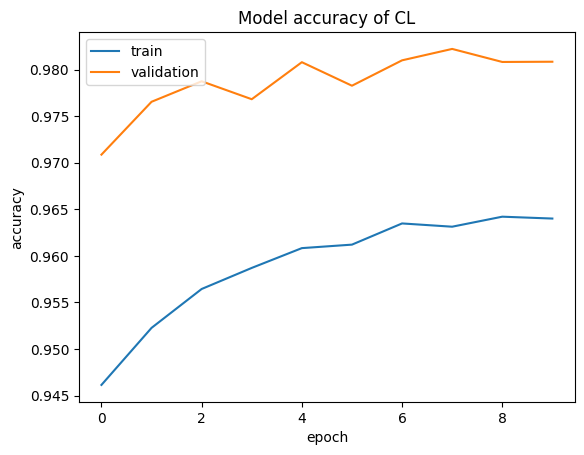

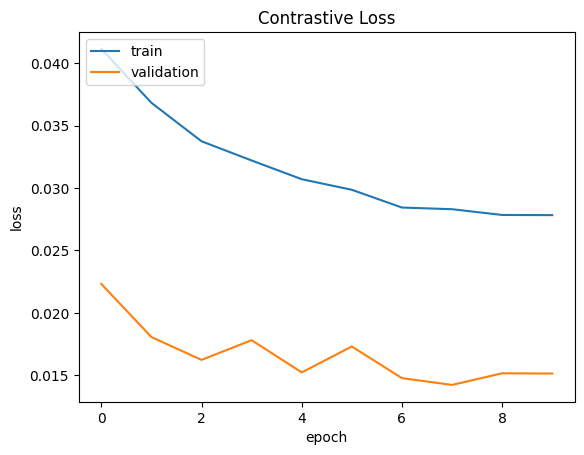

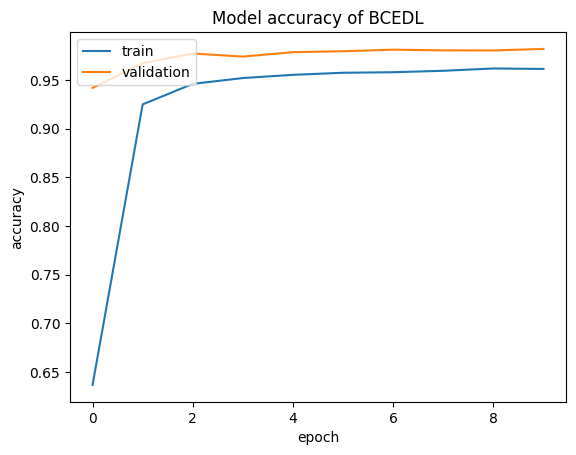

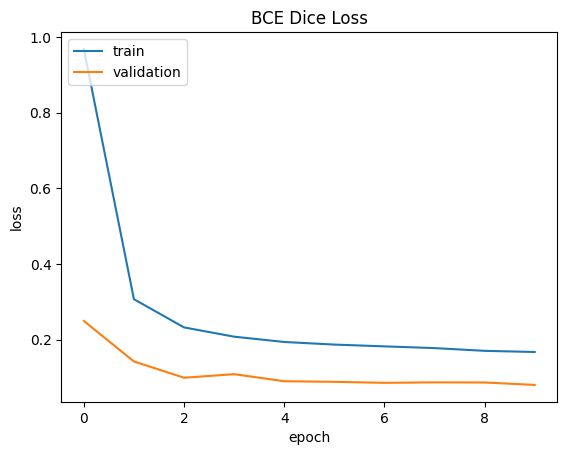

In [37]:
# Plot the accuracy of contrastive loss
plt_metric(history=history1.history, metric="accuracy", title="Model accuracy of CL")

# Plot the contrastive loss
plt_metric(history=history1.history, metric="loss", title="Contrastive Loss")

# Plot the accuracy of BCE dice loss
plt_metric(history=history2.history, metric="accuracy", title="Model accuracy of BCEDL")

# Plot the BCE dice loss
plt_metric(history=history2.history, metric="loss", title="BCE Dice Loss")

## Evaluate the model

In [38]:
# contrastive loss evaluation
results1 = siamese1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results1)

625/625 [==============================] - 4s 6ms/step - loss: 0.0130 - accuracy: 0.9833
test loss, test acc: [0.013040748424828053, 0.983299970626831]


In [39]:
# bce dice loss evaluation
results2 = siamese2.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results2)

625/625 [==============================] - 4s 6ms/step - loss: 0.0673 - accuracy: 0.9839
test loss, test acc: [0.06729840487241745, 0.9839000105857849]


## Visualize the predictions

625/625 [==============================] - 3s 5ms/step


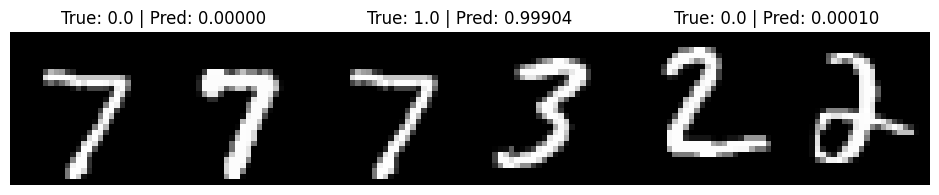

In [32]:
# contrastive loss evaluation
predictions1 = siamese1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions1, test=True)

In [ ]:
# cBCE dice loss evaluation
predictions2 = siamese2.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions2, test=True)

**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Siamese%20Network-black.svg)](https://huggingface.co/keras-io/siamese-contrastive) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Siamese%20Network-black.svg)](https://huggingface.co/spaces/keras-io/siamese-contrastive) |